## 这是用于测试 DEM 数据中坡度问题的文件

In [20]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import shapely
from CPP_Planner import CPP_Planner_Kit

In [21]:
opti_path = '../PSO_opt_result/opt4/pso_result.csv'
real_swath_path = '../Scratch/test_Load_Shp/test_shps/swath_group_1.shp'
straight_swath_path = 'GIS_data/straight_swaths/straight_swaths.shp'
opti_parameters = pd.read_csv(opti_path)
real_swath = gpd.read_file(real_swath_path)
straight_swath = gpd.read_file(straight_swath_path)
all_land = gpd.read_file('../Scratch/test_Load_Shp/shp_file/村地和道路/村地地块区域.shp')
print(opti_parameters.shape)
print(len(straight_swath), end=' ')
print(len(real_swath))

(100, 6)
28 28


In [22]:
# 提取地形图
with rasterio.open('GIS_data/路径规划优化用数据/2m_pClouds_regen_dem_cm.tif') as dem_src:
    dem_array = dem_src.read(1)
with rasterio.open('GIS_data/路径规划优化用数据/Aspect_clip_pcGen_2m_cm1.tif') as aspect_src:
    aspect_array = aspect_src.read(1)
with rasterio.open('GIS_data/路径规划优化用数据/Slope_clip_pcGen_2m_cm1.tif') as slope_src:
    slope_array = slope_src.read(1)
with rasterio.open('GIS_data/路径规划优化用数据/Curvatu_clip_pcGen_2m_cm1.tif') as curvature_src:
    curvature_array = curvature_src.read(1)
[dem_array.shape, aspect_array.shape, slope_array.shape, curvature_array.shape]

[(507, 440), (507, 440), (507, 440), (507, 440)]

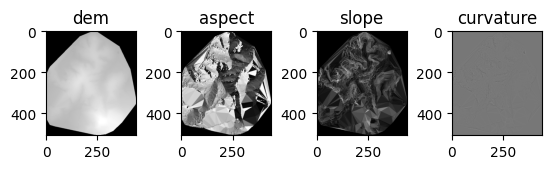

In [23]:
# 处理数据
dem_array[dem_array == dem_array.min()] = -1
aspect_array[aspect_array == aspect_array.min()] = -1
slope_array[slope_array == slope_array.min()] = -1
curvature_array[curvature_array == curvature_array.min()] = -1
_, ax = plt.subplots(nrows=1, ncols=4)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for temp_array, temp_ax, temp_name in zip([dem_array, aspect_array, slope_array, curvature_array], ax.flatten(), ['dem', 'aspect', 'slope', 'curvature']):
    temp_ax.imshow(temp_array, cmap='gray')
    temp_ax.set_title(temp_name)

### 对坡度进行分类

EPSG:32651


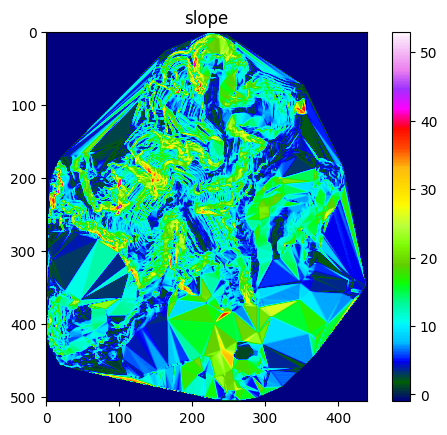

In [24]:
slope_crs = slope_src.crs
print(slope_crs)
plt.imshow(slope_array, cmap='gist_ncar')
plt.title('slope')
plt.colorbar()

<AxesSubplot: >

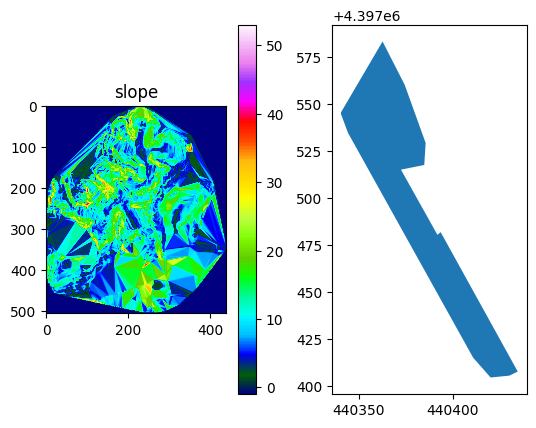

In [25]:
fig, ax = plt.subplots(ncols=2, nrows=1)
cax = ax[0].imshow(slope_array, cmap='gist_ncar')
fig.colorbar(cax, ax=ax[0], orientation='vertical')
ax[0].set_title('slope')
single_land = CPP_Planner_Kit.get_single_shp(all_land, 0)
single_land.plot(ax=ax[1])

In [26]:
from rasterio.mask import mask
single_land_geom = single_land.geometry.values.tolist()
with rasterio.open('GIS_data/路径规划优化用数据/Slope_clip_pcGen_2m_cm1.tif') as src:
    origin_image = src.read(1)
    out_image, out_transform = mask(src, single_land_geom, crop=True)
    out_meta = src.meta.copy()
out_image[out_image == out_image.min()] = -1
origin_image[origin_image == origin_image.min()] = -1

# 可拖拉机耕作机械的地块索引
arable_land_ind = [0, 1, 4, 5, 6, -1]

[<POLYGON ((440340.4 4397545.529, 440362.512 4397583.229, 440374.257 4397560....>]


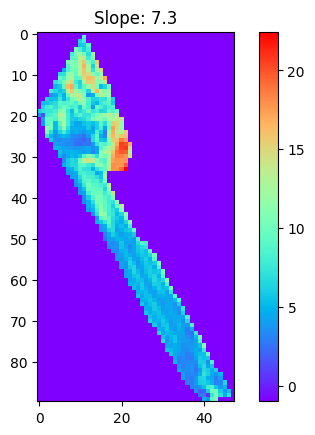

In [44]:
print(single_land_geom)
plt.imshow(out_image[0, :, :], cmap='rainbow')
plt.title('Slope: 7.3')
plt.colorbar()

### 显示所有地块内的坡度情况（有农机拖拉机耕作的地块）

7.3
3.5
4.6
6.1
7.3


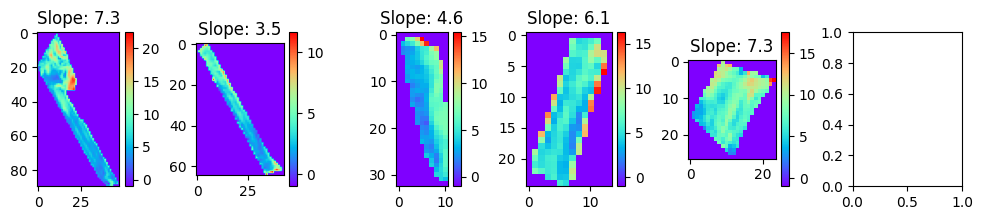

In [42]:
slope_src = rasterio.open('GIS_data/路径规划优化用数据/Slope_clip_pcGen_2m_cm1.tif')
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 2))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
i = 0
for temp_land_ind, temp_ax in zip(arable_land_ind, ax.flatten()):
    i += 1
    if i == 6:
        break
    temp_land = CPP_Planner_Kit.get_single_shp(all_land, temp_land_ind)
    temp_single_land_geom = temp_land.geometry.values.tolist()
    temp_out_image, temp_out_transform = mask(slope_src, temp_single_land_geom, crop=True)
    temp_out_image[temp_out_image == temp_out_image.min()] = -1
    temp_im = temp_ax.imshow(temp_out_image[0, :, :], cmap='rainbow')
    cbar = fig.colorbar(temp_im, ax=temp_ax, orientation='vertical')
    # temp_ax.set_title('Slope ind: {}'.format(temp_land_ind + 1))
    temp_mean_slope = np.mean(temp_out_image[temp_out_image != -1])
    temp_mean_slope = round(temp_mean_slope, 1)
    print(temp_mean_slope)
    temp_ax.set_title('Slope: ' + str(temp_mean_slope))

### 查看第一块地块的情况：将坡度“归一化，标准化”后的坡度的变化情况
1. 仅对非0坡度的区域进行操作
2. 标准化方法：取 非0区域 的平均值，并对所有区域减去其平均值

Text(0.5, 1.0, 'Long Area')

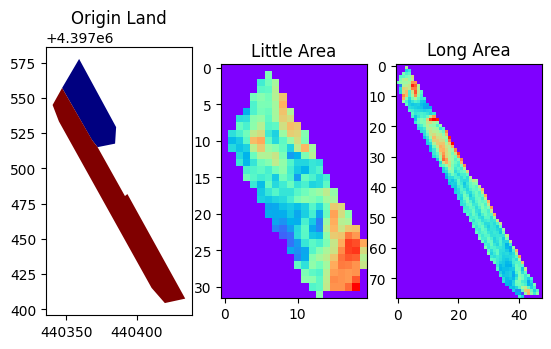

In [29]:
# 读取分离地块的数据
seperated_land = gpd.read_file('GIS_data/路径规划优化用数据/seperate_land_0.shp')
seperated_land_1 = CPP_Planner_Kit.get_single_shp(seperated_land, 0)
seperated_land_2 = CPP_Planner_Kit.get_single_shp(seperated_land, 1)
seperated_land_1_raster, seperated_land_1_trans = mask(slope_src, seperated_land_1.geometry.values.tolist(), crop=True)
seperated_land_2_raster , seperated_land_2_trans = mask(slope_src, seperated_land_2.geometry.values.tolist(), crop=True)
seperated_land_1_raster[seperated_land_1_raster == seperated_land_1_raster.min()] = -1
seperated_land_2_raster[seperated_land_2_raster == seperated_land_2_raster.min()] = -1

fig, axes = plt.subplots(nrows=1, ncols=3)
seperated_land.plot(ax=axes[0], cmap='jet')
axes[0].set_title('Origin Land')
axes[1].imshow(seperated_land_1_raster[0, :, :], cmap='rainbow')
axes[1].set_title('Little Area')
axes[2].imshow(seperated_land_2_raster[0, :, :], cmap='rainbow')
axes[2].set_title('Long Area')

### 计算当前的坡度“变化值”
 - 即当前点的坡度减去平局坡度，平均坡度的计算不包括地块区域外的坡度（即-1）

In [30]:
sep_all_mean_1 = np.mean(seperated_land_1_raster)
sep_all_mean_2 = np.mean(seperated_land_2_raster)
print('All means: \n', '    ', end='')
print(sep_all_mean_1, sep_all_mean_2)

sep_only_mean_1 = np.mean(seperated_land_1_raster[seperated_land_1_raster != -1])
sep_only_mean_2 = np.mean(seperated_land_2_raster[seperated_land_2_raster != -1])
print('------------------------------')
print('Mean in polygon: \n', '    ', end='')
print(sep_only_mean_1, sep_only_mean_2)

print('------------------------------')
print('Min in polygon: \n', '    ', end='')
raster_min_1 = np.min(seperated_land_1_raster[seperated_land_1_raster != -1]) 
raster_min_2 = np.min(seperated_land_2_raster[seperated_land_2_raster != -1]) 
print(raster_min_1, end=' ')
print(raster_min_2)

All means: 
     3.9462714 0.19899978
------------------------------
Mean in polygon: 
     10.428208 5.7863755
------------------------------
Min in polygon: 
     2.0975325 0.36518544


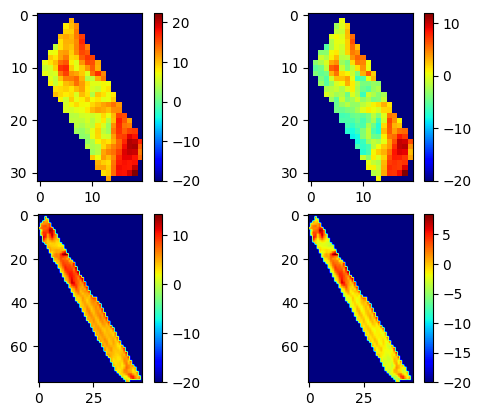

In [31]:
# 显示
# 更改最小值
NODATA = -20
colormap = 'jet'
seperated_land_1_raster[seperated_land_1_raster == -1] = NODATA
seperated_land_2_raster[seperated_land_2_raster == -1] = NODATA
_, axes = plt.subplots(ncols=2, nrows=2)
im = axes[0][0].imshow(seperated_land_1_raster[0, :, :], cmap=colormap)
cbar = plt.colorbar(im, ax=axes[0][0], orientation='vertical')
# sub_min_1 = seperated_land_1_raster.copy()
# sub_min_1[sub_min_1 != NODATA] = sub_min_1[sub_min_1 != NODATA] - raster_min_1
sub_mean_1 = seperated_land_1_raster.copy()
sub_mean_1[sub_mean_1 != NODATA] = sub_mean_1[sub_mean_1 != NODATA] - sep_only_mean_1
# sub_mean_1 -= (sep_only_mean_1)
# colorbar
# im = axes[0][1].imshow(sub_min_1[0, :, :], cmap='rainbow')
im = axes[0][1].imshow(sub_mean_1[0, :, :], cmap=colormap)
cbar = plt.colorbar(im, ax=axes[0][1], orientation='vertical')

im = axes[1][0].imshow(seperated_land_2_raster[0, :, :], cmap=colormap)
cbar = plt.colorbar(im, ax=axes[1][0], orientation='vertical')
# sub_min_2 = seperated_land_2_raster.copy()
# sub_min_2[sub_min_2 != NODATA] = sub_min_2[sub_min_2 != NODATA] - raster_min_2
sub_mean_2 = seperated_land_2_raster.copy()
sub_mean_2[sub_mean_2 != NODATA] = sub_mean_2[sub_mean_2 != NODATA] - sep_only_mean_2
# sub_mean_2 -= (sep_only_mean_2)
# im = axes[1][1].imshow(sub_min_2[0, :, :], cmap='rainbow')
im = axes[1][1].imshow(sub_mean_2[0, :, :], cmap=colormap)
cbar = plt.colorbar(im, ax=axes[1][1], orientation='vertical')


In [32]:
seperated_land_1_trans

Affine(2.0, 0.0, 440345.94999999995,
       0.0, -2.0, 4397578.3440000005)